In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.feature as skft
import sys
import os

sys.path.append("../")
from stereovis.framed.algorithms.mrf import StereoMRF
from stereovis.utils.frames_io import load_ground_truth

(288, 384)


/Users/admin/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


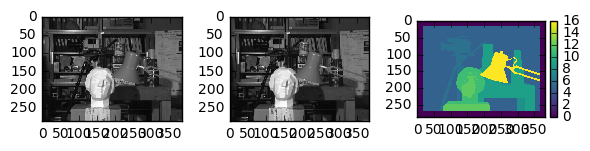

Image resolution: (288, 384)
Max disparity: 16


In [5]:
# Read left and right images as well as ground truth
img_left = skio.imread("../data/demo_samples/tsukuba_l.png", as_grey=True)
img_right = skio.imread("../data/demo_samples/tsukuba_r.png", as_grey=True)
ground_truth = load_ground_truth("../data/demo_samples/tsukuba_gt.pgm")
print(ground_truth.shape)


# since the images are too large, e.g. 1980 x 2880, scale them down
# NOTE: rescale the disparity too!
scale_down_factor = 1.0
if scale_down_factor != 1.0:
    from skimage.transform import rescale, resize
    img_left = rescale(img_left, 1.0/scale_down_factor, preserve_range=True)
    img_right = rescale(img_right, 1.0/scale_down_factor, preserve_range=True)
    ground_truth = rescale(ground_truth, 1.0/scale_down_factor, preserve_range=True)/scale_down_factor

ground_truth = ground_truth.astype('int16')

skio.imshow_collection([img_left, img_right, ground_truth])
plt.show()
print("Image resolution: {}".format(img_left.shape))
max_disp = np.max(ground_truth)
print("Max disparity: {}".format(max_disp))

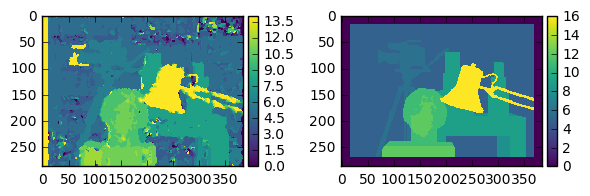

In [25]:
# Initialise a MRF and calculate the some (possible sub-optimal) disparity assignemnt
img_res = img_left.shape
mrf = StereoMRF(img_res, n_levels=max_disp-1)
disp_map = mrf.lbp(img_left, img_right, n_iter=10)
skio.imshow_collection([disp_map, ground_truth])

In [39]:
# Animate the "diffusion"-like process (not really diffusion as it converges to a non-maximum entropy state)

output_folder = "../data/demo_samples/mrf_animation"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
for i in range(40):
    disp_map = mrf.lbp(img_left, img_right, n_iter=i)
    row_pixel_distr = disp_map[150, :]
    axs[0].imshow(disp_map, interpolation='none')
    axs[0].set_title("2-D depth landscape")
    axs[0].set_axis_off()
    axs[0].plot(range(disp_map.shape[1]), np.repeat(150, disp_map.shape[1])) # draw line
    axs[1].plot(range(disp_map.shape[1]), row_pixel_distr)
    axs[1].set_title("1-D depth landscape at row=150")
    axs[1].set_ylim([0, 16])
    
    plt.savefig(os.path.join(output_folder, str(i) + '.png'))
    
    axs[0].clear()
    axs[1].clear()
fig.clear()